In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import os



   FID_             FULLNAME   RH     DateTime  MAX15  HR_2  HR_72  w_depth  \
0     0  E LITTLE CREEK ROAD  0.0  Sep16_19_10    0.0   0.0    0.0      0.0   
1     1  E LITTLE CREEK ROAD  0.0  Sep16_19_10    0.0   0.0    0.0      0.0   
2     2  E LITTLE CREEK ROAD  0.0  Sep16_19_10    0.0   0.0    0.0      0.0   
3     3  E LITTLE CREEK ROAD  0.0  Sep16_19_10    0.0   0.0    0.0      0.0   
4     4  E LITTLE CREEK ROAD  0.0  Sep16_19_10    0.0   0.0    0.0      0.0   

   TD_HR       ELV          DTW       TWI  
0   0.61  3.449655  2032.268709  7.511351  
1   0.61  3.351578  2289.101516  7.397089  
2   0.61  3.355286  2170.271564  7.548316  
3   0.61  3.489952  2261.629379  8.816202  
4   0.61  3.421316  2262.551560  9.006661  


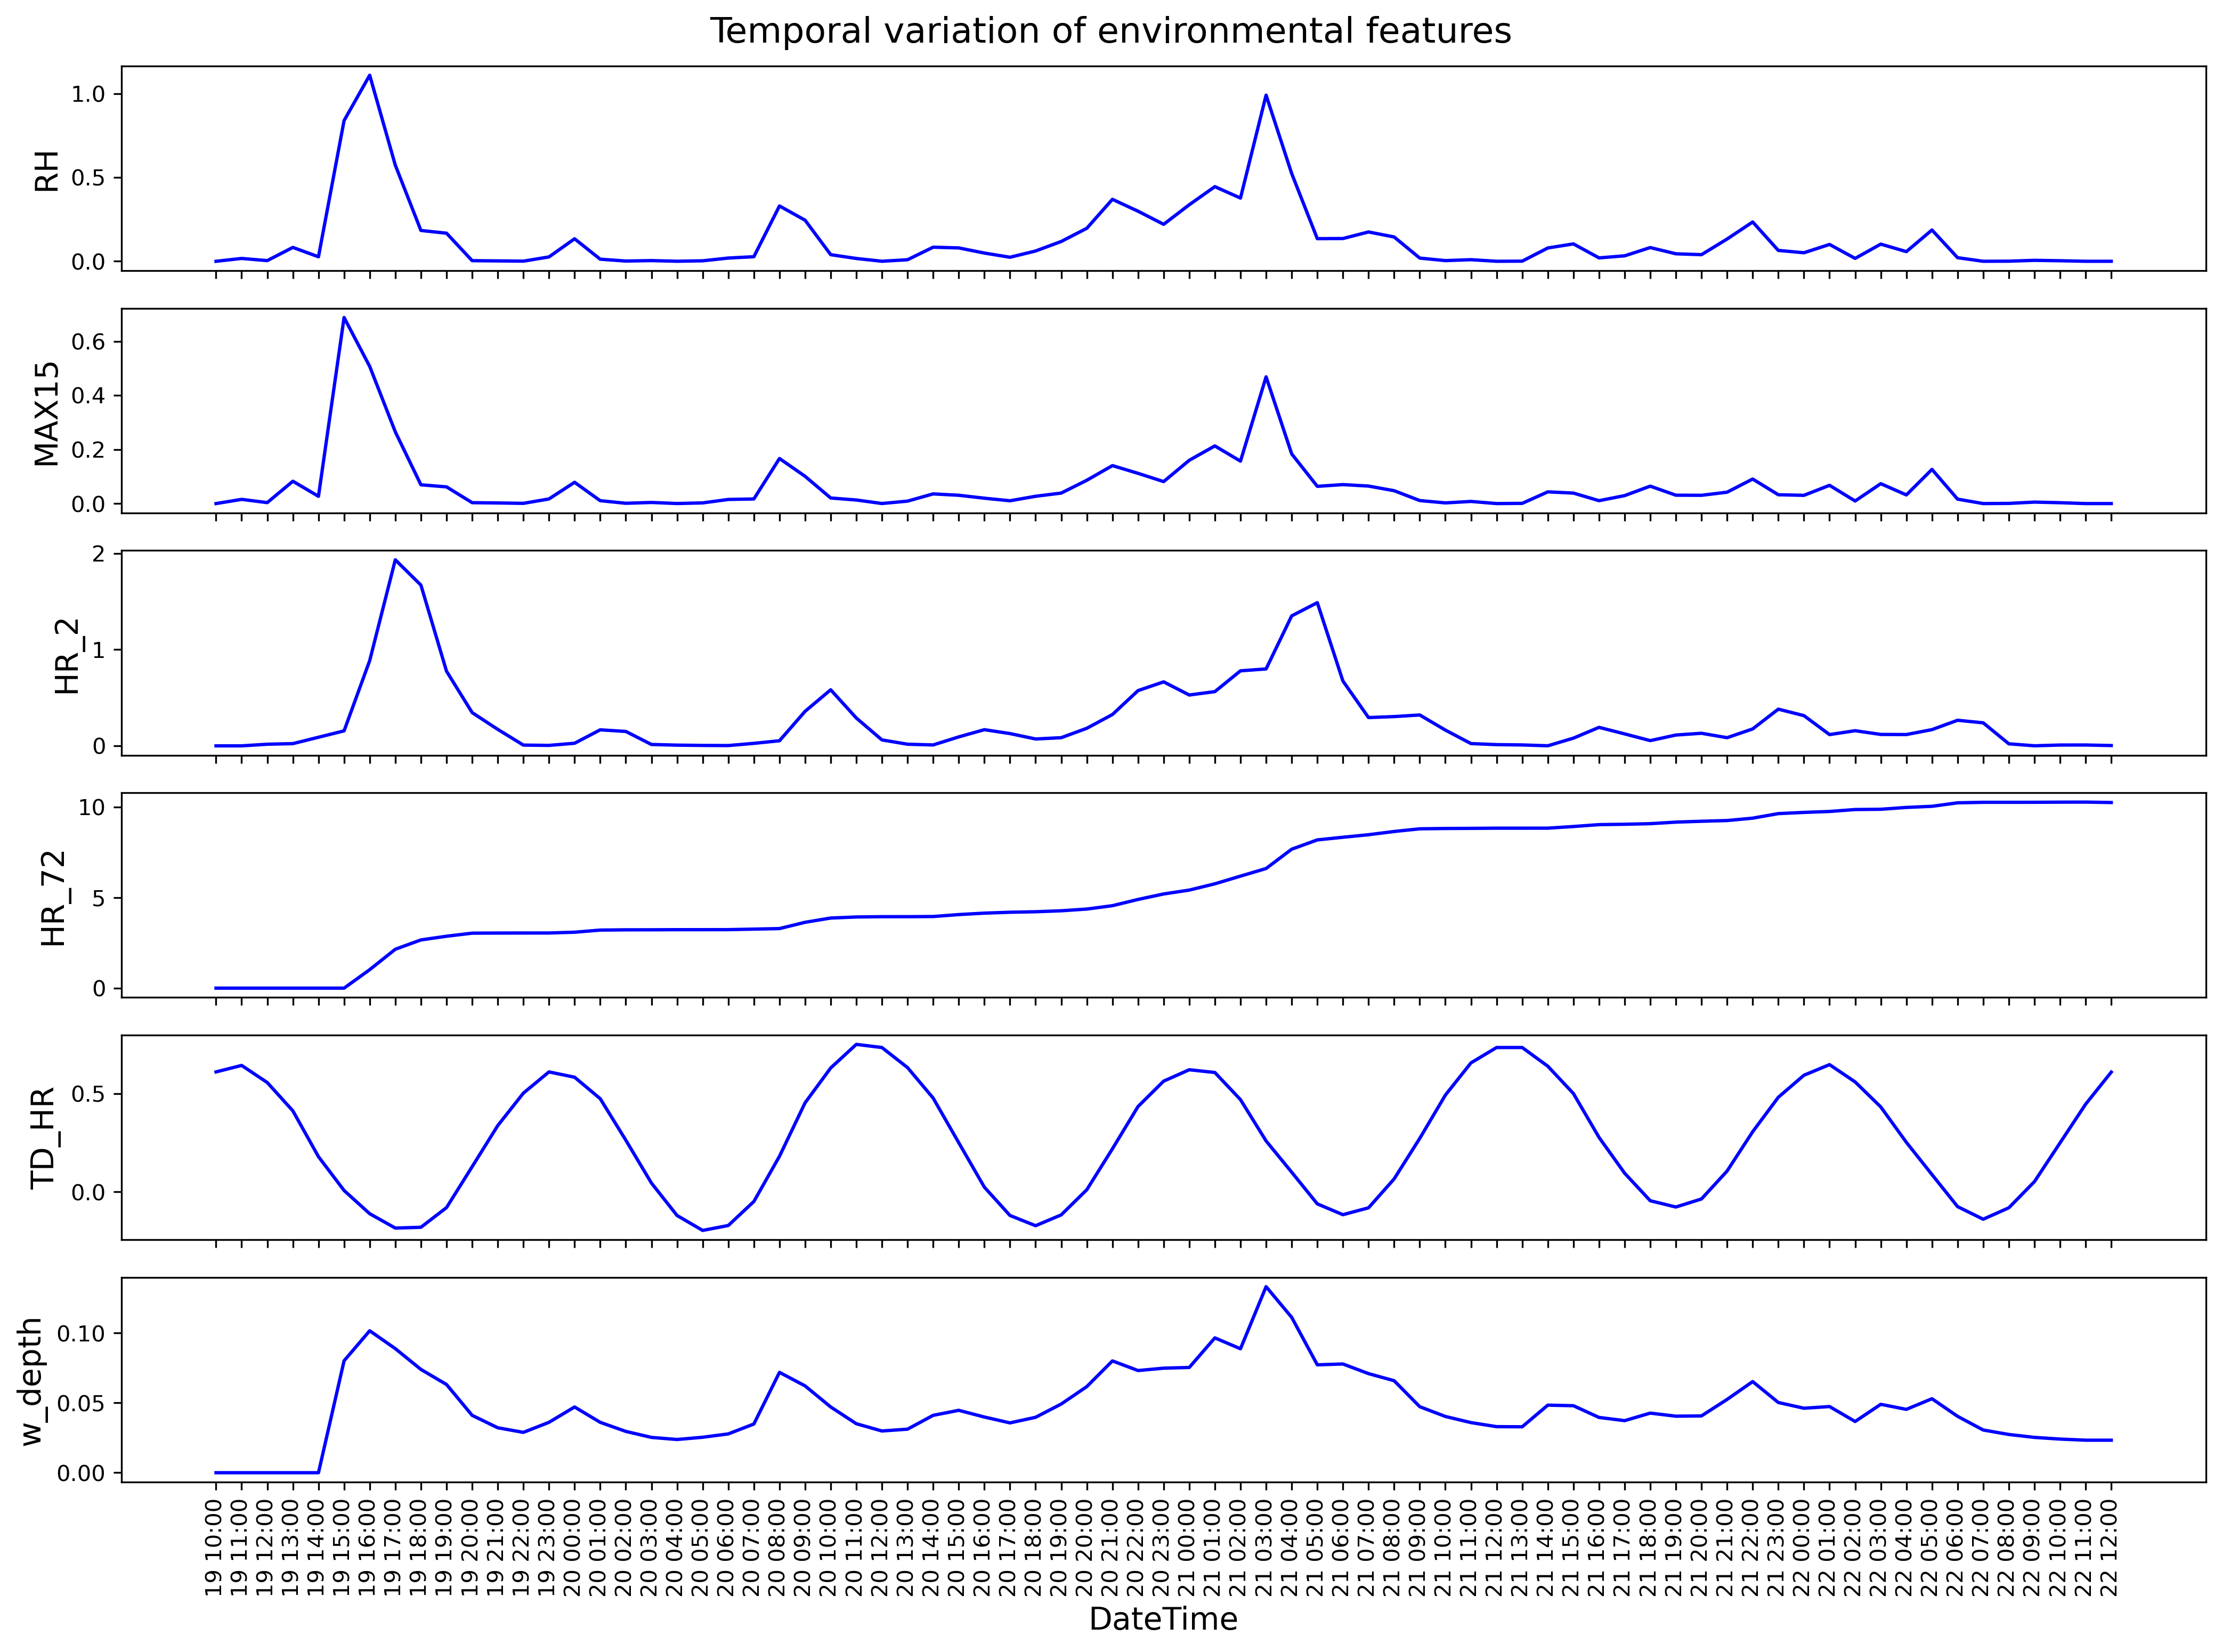

In [12]:
path = 'events/2016_09_21.csv'
df = pd.read_csv(path)

print(df.head())


df['DateTime'] = df['DateTime'].apply(lambda x: x.split('_')[1] + ' ' + x.split('_')[2] + ':00')
df['DateTime1'] = pd.to_datetime(df['DateTime'], format='%d %H:%M')


cols = [ 'RH', 'MAX15', 'HR_2', 'HR_72', 'TD_HR' ,'w_depth']
df_features = df[['DateTime'] + cols]


df_median = df_features.groupby('DateTime').median()


fig, axes = plt.subplots(len(cols), 1, figsize=(14, 10), sharex=True, dpi=300)
for i, feature in enumerate(cols):
    axes[i].plot(df_median.index, df_median[feature], label=feature, color='b')
    
    axes[i].set_ylabel(feature, fontsize=14)

axes[-1].set_xlabel('DateTime', fontsize=14)
fig.suptitle('Temporal variation of environmental features', fontsize=16)
plt.tight_layout()
plt.xticks(rotation=90)
plt.show()

In [13]:
directory = 'events'
csv_files = [f for f in os.listdir(directory) if f.endswith('.csv')]


train_files = csv_files[:14]
test_files = csv_files[14:18]


def load_data(files, directory):
    data = []
    for file in files:
        df = pd.read_csv(os.path.join(directory, file))
        data.append(df)
    return pd.concat(data, ignore_index=True)


train_data = load_data(train_files, directory)
print(train_data.head(),train_data.shape)


test_data = load_data(test_files, directory)
print(test_data.head(),test_data.shape)

train_data['sample_weight'] = train_data['w_depth'].apply(lambda x: 1 if x < 0.2 else 2)
sample_weight = train_data['sample_weight']

X_train = train_data.drop(columns=['w_depth', 'FID_', 'FULLNAME',  'DateTime', 'sample_weight'])
y_train = train_data['w_depth']
X_test = test_data.drop(columns=['w_depth', 'FID_', 'FULLNAME', 'DateTime'])
y_test = test_data['w_depth']
print(X_train, X_test, y_train, y_test)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

   FID_             FULLNAME        RH     DateTime     MAX15  HR_2  HR_72  \
0     0  E LITTLE CREEK ROAD  0.001150  Oct17_28_23  0.001150   0.0    0.0   
1     1  E LITTLE CREEK ROAD  0.000987  Oct17_28_23  0.000987   0.0    0.0   
2     2  E LITTLE CREEK ROAD  0.001071  Oct17_28_23  0.001071   0.0    0.0   
3     3  E LITTLE CREEK ROAD  0.000838  Oct17_28_23  0.000838   0.0    0.0   
4     4  E LITTLE CREEK ROAD  0.000907  Oct17_28_23  0.000907   0.0    0.0   

   w_depth  TD_HR       ELV          DTW       TWI  
0      0.0 -0.103  3.449655  2032.268709  7.511351  
1      0.0 -0.103  3.351578  2289.101516  7.397089  
2      0.0 -0.103  3.355286  2170.271564  7.548316  
3      0.0 -0.103  3.489952  2261.629379  8.816202  
4      0.0 -0.103  3.421316  2262.551560  9.006661   (6933691, 12)
   FID_             FULLNAME   RH     DateTime  MAX15  HR_2  HR_72  w_depth  \
0     0  E LITTLE CREEK ROAD  0.0  Jan17_01_23    0.0   0.0    0.0      0.0   
1     1  E LITTLE CREEK ROAD  0.0  Jan17_

In [14]:
rf_model = RandomForestRegressor(
    n_estimators=150,      
    max_depth=40,
    n_jobs=-1,

    random_state=42
)
rf_model.fit(X_train_scaled, y_train, sample_weight=sample_weight)



RandomForestRegressor(max_depth=40, n_estimators=150, n_jobs=-1,
                      random_state=42)

In [15]:
y_pred_rf_train = rf_model.predict(X_train_scaled)
y_pred_rf_test = rf_model.predict(X_test_scaled)



rf_train_r2 = r2_score(y_train, y_pred_rf_train)
rf_test_r2 = r2_score(y_test, y_pred_rf_test)


print(f'Random Forest - Training R^2: {rf_train_r2}')
print(f'Random Forest - Testing R^2: {rf_test_r2}')

Random Forest - Training R^2: 0.9946066631533406
Random Forest - Testing R^2: 0.9471059724180827


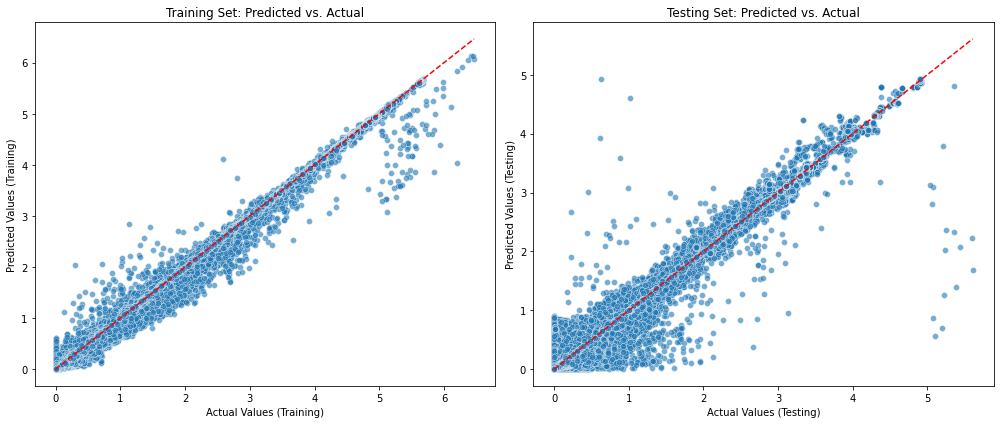

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns


plt.figure(figsize=(14, 6))


plt.subplot(1, 2, 1)
sns.scatterplot(x=y_train, y=y_pred_rf_train, alpha=0.6)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--')  # Reference line
plt.xlabel('Actual Values (Training)')
plt.ylabel('Predicted Values (Training)')
plt.title('Training Set: Predicted vs. Actual')


plt.subplot(1, 2, 2)
sns.scatterplot(x=y_test, y=y_pred_rf_test, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Reference line
plt.xlabel('Actual Values (Testing)')
plt.ylabel('Predicted Values (Testing)')
plt.title('Testing Set: Predicted vs. Actual')

plt.tight_layout()
plt.show()


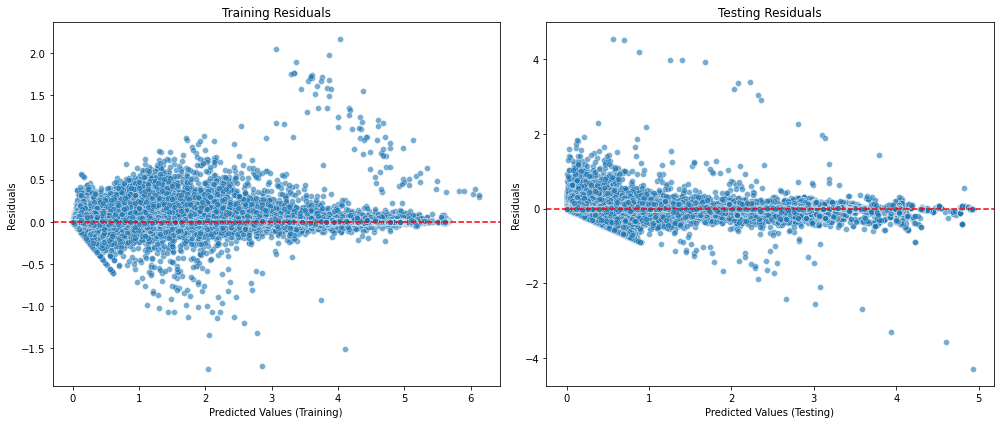

In [17]:
train_residuals = y_train - y_pred_rf_train
test_residuals = y_test - y_pred_rf_test


plt.figure(figsize=(14, 6))


plt.subplot(1, 2, 1)
sns.scatterplot(x=y_pred_rf_train, y=train_residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Values (Training)')
plt.ylabel('Residuals')
plt.title('Training Residuals')


plt.subplot(1, 2, 2)
sns.scatterplot(x=y_pred_rf_test, y=test_residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Values (Testing)')
plt.ylabel('Residuals')
plt.title('Testing Residuals')

plt.tight_layout()
plt.show()

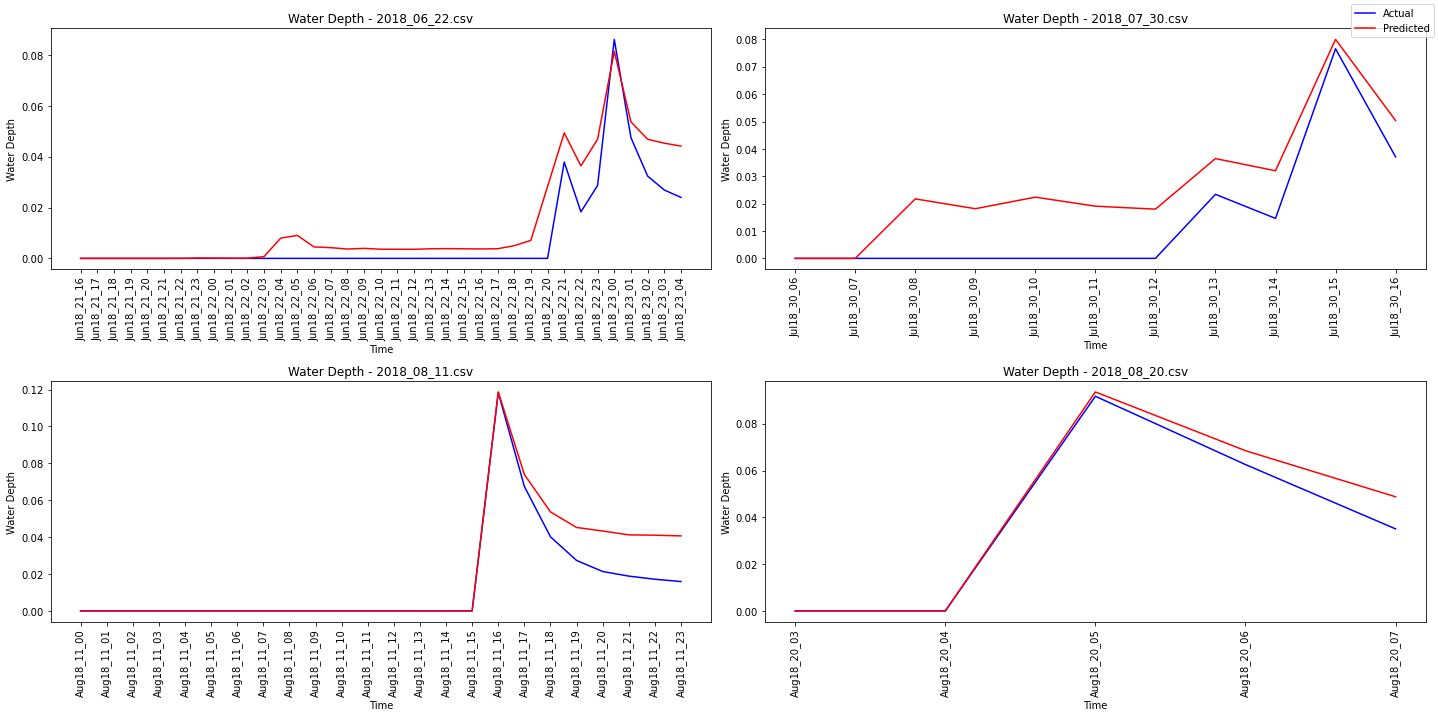

In [18]:
import matplotlib.pyplot as plt


fig, axes = plt.subplots(2, 2, figsize=(20, 10))  


axes = axes.flatten()


for i, path in enumerate(['events/2018_06_22.csv','events/2018_07_30.csv', 'events/2018_08_11.csv', 'events/2018_08_20.csv']):
    df1 = pd.read_csv(path)
    test_data1 = df1

    X_test1 = test_data1.drop(columns=['w_depth', 'FID_', 'FULLNAME', 'DateTime'])
    y_test1 = test_data1['w_depth']

    X_test_scaled1 = scaler.transform(X_test1)
    y_pred1 = rf_model.predict(X_test_scaled1)

    df1['y_pred'] = y_pred1
    cols1 = ['y_pred', 'w_depth']
    df1 = df1[['DateTime'] + cols1]

   
    df_median1 = df1.groupby('DateTime').median()

    
    axes[i].plot(df_median1.index, df_median1['w_depth'], color='blue', label='Actual')
    axes[i].plot(df_median1.index, df_median1['y_pred'], color='red', label='Predicted')

 
    axes[i].set_title(f'Water Depth - {path.split("/")[-1]}')
    axes[i].set_xlabel('Time')
    axes[i].set_ylabel('Water Depth')
    axes[i].tick_params(axis='x', rotation=90)


plt.tight_layout()
fig.legend(['Actual', 'Predicted'], loc='upper right')
plt.show()


In [19]:
importances = rf_model.feature_importances_


feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
})


feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print(feature_importance_df)

  Feature  Importance
5     ELV    0.704603
6     DTW    0.109792
7     TWI    0.090946
3   HR_72    0.052692
4   TD_HR    0.019839
2    HR_2    0.010243
0      RH    0.007752
1   MAX15    0.004133


/usr/local/anaconda/lib/python3.9/site-packages/sklearn/inspection/_plot/partial_dependence.py:735: UserWarning: Attempting to set identical bottom == top == 0.20633369142953928 results in singular transformations; automatically expanding.
  ax.set_ylim(self.pdp_lim[1])


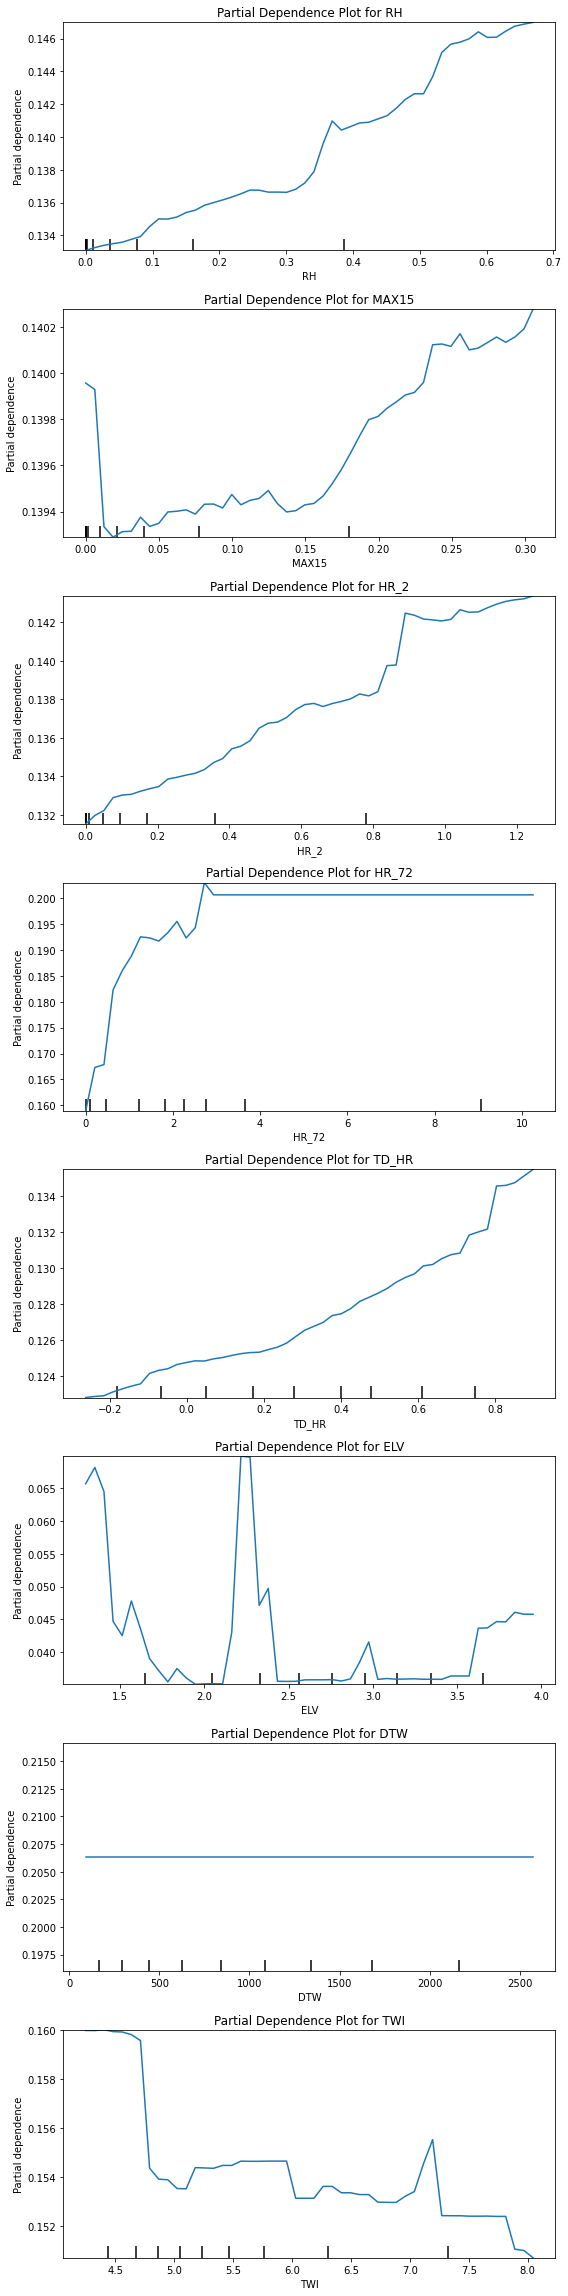

In [ ]:
from sklearn.inspection import plot_partial_dependence

features = X_train.columns
fig, ax = plt.subplots(nrows=len(features), figsize=(8, 4 * len(features)))

for i, feature in enumerate(features):
    plot_partial_dependence(
        rf_model, X_train, [feature], ax=ax[i], grid_resolution=50
    )
    ax[i].set_title(f'Partial Dependence Plot for {feature}')

plt.tight_layout()
plt.show()